In [2]:
import os
import re
from pathlib import Path
import time
import tqdm

import numpy as np
import pandas as pd 
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sn

import torch 
import torch.nn as nn
import torch.nn.functional
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

register_matplotlib_converters()

FRED Federal Reserve Ecomonic Database 
Sales date of alcohol drinks i millions of dollar from 1992 to 2019

In [3]:
#The dataset is on Data folder of tthis repo
data_path = Path("./Data/Alcohol_Sales.csv")
data = pd.read_csv(data_path, index_col=0, parse_dates=True)
data

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221
...,...
2018-09-01,12396
2018-10-01,13914
2018-11-01,14174


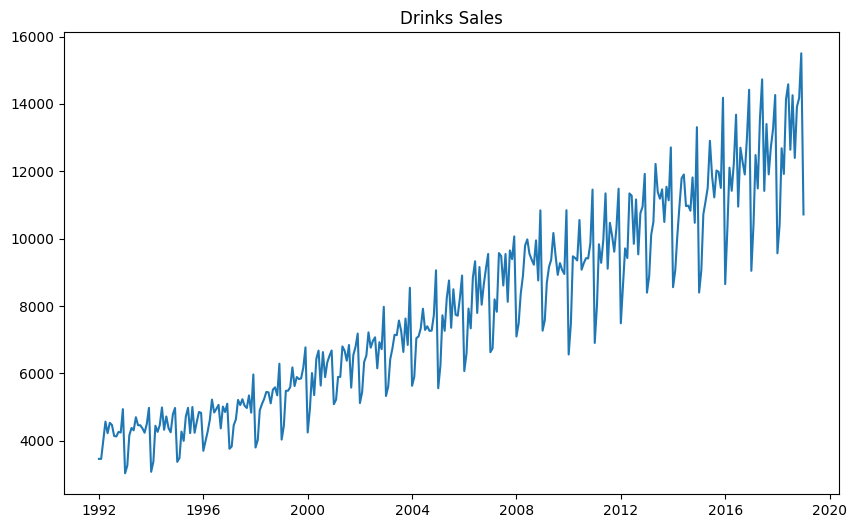

In [4]:
#Plot of the Drink sales time series
plt.figure(figsize=(10,6))
plt.title("Drinks Sales")
plt.plot(data)

In [21]:
#Defining size of data slipts

test_size = 12

column_name = data.columns[0]
train_array = data[column_name][:-test_size].to_numpy()
test_array = data[column_name][-test_size:].to_numpy()

#Normalizing data
scaler = MinMaxScaler(feature_range=(-1,1))

#To avoid data lakage use just the train data
scaler.fit(train_array.reshape(-1,1))
train_norm = scaler.transform(train_array.reshape(-1,1))
train_norm = torch.FloatTensor(train_norm).view(-1)



In [22]:
# Define the window size of the LSTM
# The window size should be at least one cycle 

window_size = 12 #One year window size


#Functions to create the labels ands windows for each iteration at the dataset
def input_data(data, window_size):
    out=[]
    L = len(data)

    for i in range(L-window_size):
        window = data[i:i+window_size]
        label = data[i+window_size: i+window_size+1]
        out.append((window, label))
    
    return out

train_data = input_data(train_norm, window_size)
len(train_data)


301

In [23]:
#Inin LSTM class
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.hidden_size = hidden_size

        #Add an LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        self.hidden = (torch.zeros(1,1,self.hidden_size),  #To predict just one output per sequence
                    torch.zeros(1,1,self.hidden_size))
    
    def forward(self, data):

        lstm_out, self.hidden = self.lstm(data.view(len(data),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(data), -1))

        return pred[-1] #We only want the last data of the predicted sequence

    
#Initialing model
torch.manual_seed(101)
model = LSTM(input_size=1, hidden_size=100, output_size=1) #One input data and one output per sequence 

#Print model configuration
print(f"\tModule name \t\t| \t Parameters Listed")
for name, parameter in model.named_parameters():
    print(f'\t {name} \t| \t {parameter.numel()}')


#Defining loss function and optmizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


	Module name 		| 	 Parameters Listed
	 lstm.weight_ih_l0 	| 	 400
	 lstm.weight_hh_l0 	| 	 40000
	 lstm.bias_ih_l0 	| 	 400
	 lstm.bias_hh_l0 	| 	 400
	 linear.weight 	| 	 100
	 linear.bias 	| 	 1


In [24]:
#Training the LSTM model

start_time = time.time() #To compute total training time

epochs_number = 100

for epoch in range(epochs_number): 
    
    for sequence, y_train in train_data:

        optimizer.zero_grad()

        model.hidden = (torch.zeros(1,1,model.hidden_size), 
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(data=sequence)

        loss = criterion(y_pred, y_train)
    
        loss.backward()
        optimizer.step()

        #Tracking batch accuracy
        print(f" Epoch: {epoch} \t | \t Loss: {round(loss.item(),4)}")


training_time = time.time() - start_time
print(f"Training duration: {training_time/60} mins")


 Epoch: 0 	 | 	 Loss: 1.2174
 Epoch: 0 	 | 	 Loss: 1.0776
 Epoch: 0 	 | 	 Loss: 0.7365
 Epoch: 0 	 | 	 Loss: 0.6339
 Epoch: 0 	 | 	 Loss: 0.6144
 Epoch: 0 	 | 	 Loss: 0.4797
 Epoch: 0 	 | 	 Loss: 0.5024
 Epoch: 0 	 | 	 Loss: 0.4658
 Epoch: 0 	 | 	 Loss: 0.4487
 Epoch: 0 	 | 	 Loss: 0.4359
 Epoch: 0 	 | 	 Loss: 0.3358
 Epoch: 0 	 | 	 Loss: 0.2115
 Epoch: 0 	 | 	 Loss: 0.5525
 Epoch: 0 	 | 	 Loss: 0.4007
 Epoch: 0 	 | 	 Loss: 0.1463
 Epoch: 0 	 | 	 Loss: 0.1154
 Epoch: 0 	 | 	 Loss: 0.0458
 Epoch: 0 	 | 	 Loss: 0.0002
 Epoch: 0 	 | 	 Loss: 0.0
 Epoch: 0 	 | 	 Loss: 0.0432
 Epoch: 0 	 | 	 Loss: 0.0509
 Epoch: 0 	 | 	 Loss: 0.0485
 Epoch: 0 	 | 	 Loss: 0.0805
 Epoch: 0 	 | 	 Loss: 0.0616
 Epoch: 0 	 | 	 Loss: 0.0118
 Epoch: 0 	 | 	 Loss: 0.0181
 Epoch: 0 	 | 	 Loss: 0.0006
 Epoch: 0 	 | 	 Loss: 0.0089
 Epoch: 0 	 | 	 Loss: 0.0003
 Epoch: 0 	 | 	 Loss: 0.0018
 Epoch: 0 	 | 	 Loss: 0.0118
 Epoch: 0 	 | 	 Loss: 0.0003
 Epoch: 0 	 | 	 Loss: 0.0163
 Epoch: 0 	 | 	 Loss: 0.0051
 Epoch: 0 	 | 	 L

In [36]:
#Predict the future based on known test data

future = 12
preds = train_norm[-window_size:].tolist()

#Set evaluations mode for LSTM
model.eval()

for i in range(future):

    sequence = torch.FloatTensor(preds[-window_size:])

    with torch.no_grad():
        
        model.hidden = (torch.zeros(1,1,model.hidden_size), 
                        torch.zeros(1,1,model.hidden_size))
        
        preds.append(model(sequence).item())

#Invert the normalized values 
predictions_unnorm = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1,1))
predictions_unnorm

array([[ 9595.01758101],
       [12637.255265  ],
       [11145.71036915],
       [13825.27526742],
       [14956.56871581],
       [11129.36025614],
       [13968.00443751],
       [11751.02610856],
       [13323.10370931],
       [13251.17639127],
       [12955.68334335],
       [10139.99563484]])

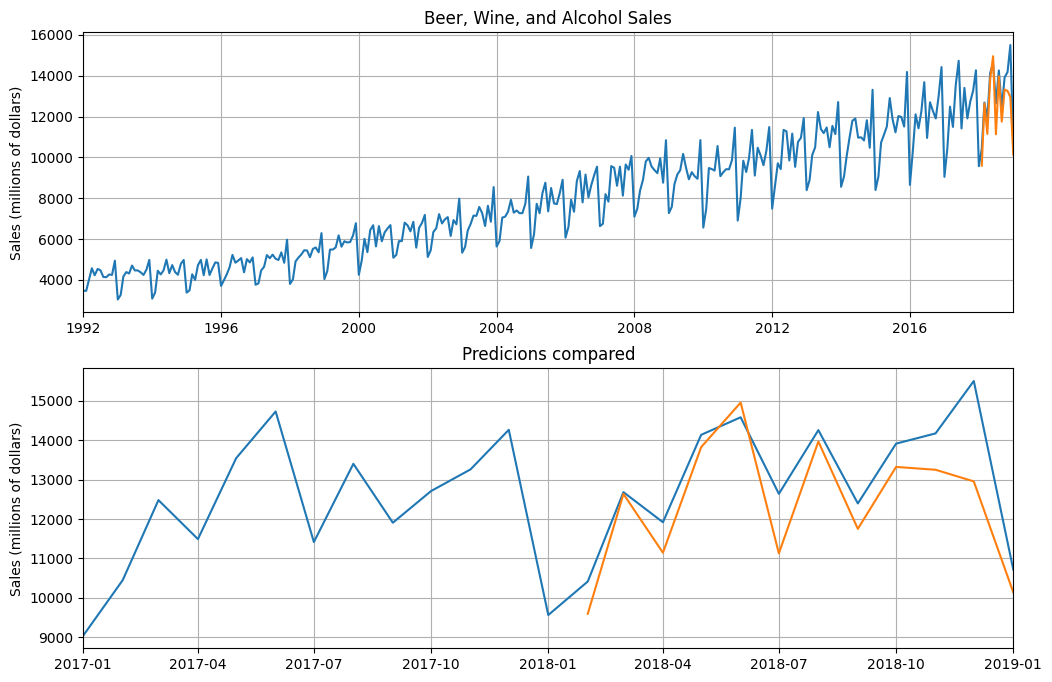

In [37]:
#Ploting predicions results and test set ground-truth
timestamp = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')

figure, [ax0,ax1] = plt.subplots(2,1,figsize=(12,8))

#Plotting wntire timeseries
ax0.set_title('Beer, Wine, and Alcohol Sales')
ax0.set_ylabel('Sales (millions of dollars)')
ax0.grid(True)
ax0.autoscale(axis='x',tight=True)
ax0.plot(data['S4248SM144NCEN'])
ax0.plot(timestamp,predictions_unnorm)

#Plotting zoomed test data
ax1.set_title('Predicions compared')
ax1.set_ylabel('Sales (millions of dollars)')
ax1.grid(True)
ax1.autoscale(axis='x',tight=True)
ax1.plot(data['S4248SM144NCEN']['2017-01-01':])
ax1.plot(timestamp,predictions_unnorm)

# Forecast into unknown future
Retraining the model using the entire dataset, and predict 12 steps into the future.

In [39]:
# Set model to back to training mode
epochs = 100
model.train()

# Scale the entire dataset
y_norm = scaler.fit_transform(data[column_name].to_numpy().reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

start_time = time.time()

for epoch in range(epochs):
    
    # train on the full set of sequences
    for sequence, y_train in all_data:  
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(sequence)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

        #Tracking batch accuracy
        print(f" Epoch: {epoch} \t | \t Loss: {round(loss.item(),4)}")


training_time = time.time() - start_time
print(f"Training duration: {training_time/60} mins")

 Epoch: 0 	 | 	 Loss: 0.0303
 Epoch: 0 	 | 	 Loss: 0.0091
 Epoch: 0 	 | 	 Loss: 0.0043
 Epoch: 0 	 | 	 Loss: 0.0044
 Epoch: 0 	 | 	 Loss: 0.0043
 Epoch: 0 	 | 	 Loss: 0.0011
 Epoch: 0 	 | 	 Loss: 0.0
 Epoch: 0 	 | 	 Loss: 0.0028
 Epoch: 0 	 | 	 Loss: 0.0001
 Epoch: 0 	 | 	 Loss: 0.0001
 Epoch: 0 	 | 	 Loss: 0.0023
 Epoch: 0 	 | 	 Loss: 0.0
 Epoch: 0 	 | 	 Loss: 0.0009
 Epoch: 0 	 | 	 Loss: 0.0002
 Epoch: 0 	 | 	 Loss: 0.0124
 Epoch: 0 	 | 	 Loss: 0.0089
 Epoch: 0 	 | 	 Loss: 0.0076
 Epoch: 0 	 | 	 Loss: 0.0032
 Epoch: 0 	 | 	 Loss: 0.0005
 Epoch: 0 	 | 	 Loss: 0.0005
 Epoch: 0 	 | 	 Loss: 0.0034
 Epoch: 0 	 | 	 Loss: 0.0108
 Epoch: 0 	 | 	 Loss: 0.0067
 Epoch: 0 	 | 	 Loss: 0.0036
 Epoch: 0 	 | 	 Loss: 0.0004
 Epoch: 0 	 | 	 Loss: 0.0018
 Epoch: 0 	 | 	 Loss: 0.0005
 Epoch: 0 	 | 	 Loss: 0.0045
 Epoch: 0 	 | 	 Loss: 0.0002
 Epoch: 0 	 | 	 Loss: 0.0003
 Epoch: 0 	 | 	 Loss: 0.0026
 Epoch: 0 	 | 	 Loss: 0.0044
 Epoch: 0 	 | 	 Loss: 0.0013
 Epoch: 0 	 | 	 Loss: 0.0001
 Epoch: 0 	 | 	 Loss

In [42]:
#Predict the future based on unknown data

window_size = 12
future = 12
preds = y_norm[-window_size:].tolist()

model.eval()

for i in range(future):

    seq = torch.FloatTensor(preds[-window_size:])

    with torch.no_grad():
        
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))  
        preds.append(model(seq).item())

#Invert the normalized values 
predictions_unnorm = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1,1))
predictions_unnorm

array([[11313.39527084],
       [13236.09662572],
       [12483.58487964],
       [14089.60067821],
       [14232.73983681],
       [13755.1543175 ],
       [15037.9505747 ],
       [13479.5441179 ],
       [14231.18268344],
       [15118.90545082],
       [17541.52682602],
       [10851.28166313]])

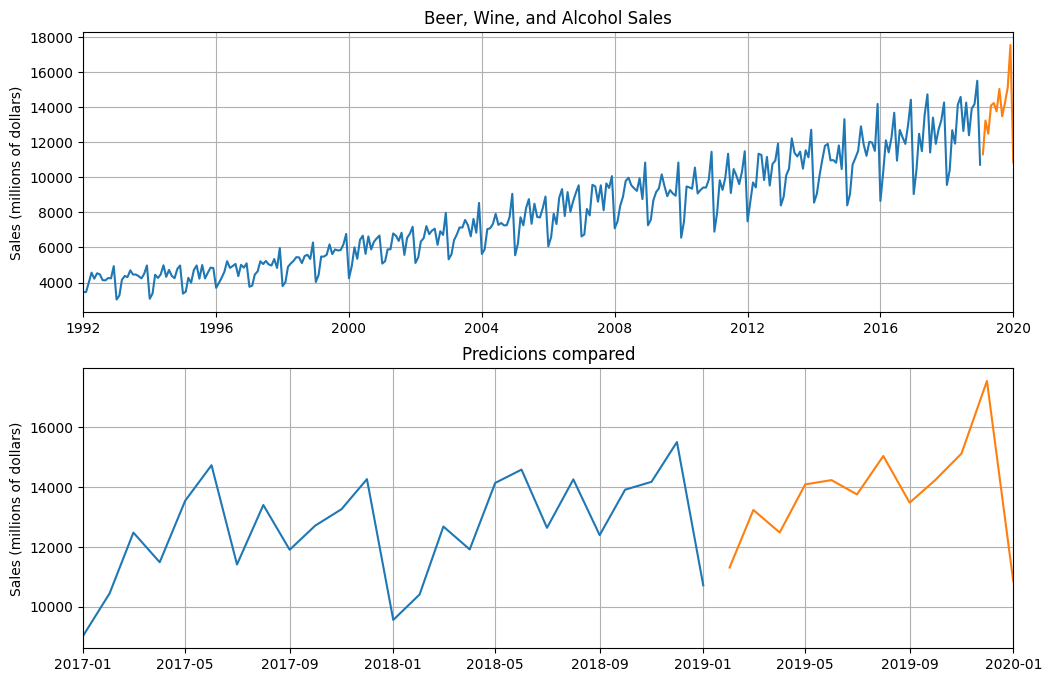

In [45]:
#Ploting predicions results and 
timestamp = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]').astype('datetime64[D]')

figure, [ax0,ax1] = plt.subplots(2,1,figsize=(12,8))

#Plotting wntire timeseries
ax0.set_title('Beer, Wine, and Alcohol Sales')
ax0.set_ylabel('Sales (millions of dollars)')
ax0.grid(True)
ax0.autoscale(axis='x',tight=True)
ax0.plot(data['S4248SM144NCEN'])
ax0.plot(timestamp,predictions_unnorm)

#Plotting zoomed test data
ax1.set_title('Predicions compared')
ax1.set_ylabel('Sales (millions of dollars)')
ax1.grid(True)
ax1.autoscale(axis='x',tight=True)
ax1.plot(data['S4248SM144NCEN']['2017-01-01':])
ax1.plot(timestamp,predictions_unnorm) 